## Inference (generate reps for) all beta-lactamase sequences we'll need in order to make the PCA plots for Fig 4.

This notebook generates the representations and stores them in pickles. It is compute heavy. Downstream notebooks call on these precomputed reps, thus it's not necessary to run this notebook in order to run downstream ones.

In [1]:
import os
import sys
import warnings
import multiprocessing as mp
import random
import pickle
import glob
import time
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline
import tensorflow as tf

sys.path.append('../common')
import data_io_utils
import paths
import utils
import constants

sys.path.append('../A003_policy_optimization/')
import A003_common
import models

sys.path.append('../A006_simulated_annealing/')
from unirep import babbler1900 as babbler

sys.path.append('../A008_analyze_chip_1/')
import A008_common

import A011_common

%reload_ext autoreload
%autoreload 2

## Inference a collection of BLAC sequences

### Evotuning sequences

In [2]:
seq_file = 'BLAC_evotuning_seqs_train_betalac2.txt'
with open(seq_file) as f:
    seqs = f.read().splitlines()
    
print(len(seqs))

62155


### Firnberg et al 2014 sequences

In [3]:
seq_files = [paths.FIRNBERG_SPLIT_0_FILE, paths.FIRNBERG_SPLIT_1_FILE, paths.FIRNBERG_SPLIT_2_FILE]
for sf in seq_files:
    data_io_utils.sync_s3_path_to_local(sf, is_single_file=True)

df = pd.concat([pd.read_csv(sf) for sf in seq_files], axis=0)

seqs += list(df['seq'])

print(len(seqs))

67354


### A011f random sequences

In [4]:
seq_file = 'A011f_BLAC_random_seqs.txt'
with open(seq_file) as f:
    rseqs = f.read().splitlines()
    
seqs += rseqs
print(len(seqs))

117354


## Some evolutionary trajectories

We want trajectories that have a lot of dynamic range. Start from the bottom and now they here.

In [5]:
traj_dir = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1/simulated_annealing/beta_lactamase')

traj_file = os.path.join(traj_dir, 'BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e.p')
data_io_utils.sync_s3_path_to_local(traj_file, is_single_file=True)

with open(traj_file, 'rb') as f:
    traj_data = pickle.load(f)
    
# traj_data['sa_results']['seq_history'] is a list of lists. rows = iterations, columns = trajectories.

20


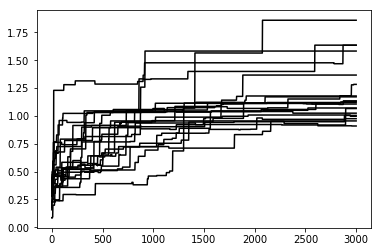

In [6]:
fit = np.array(traj_data['sa_results']['fitness_history'])
mask = np.logical_and(np.min(fit, axis=0) < 0.4, np.max(fit, axis=0) > 0.95)

print(np.sum(mask))

sidx = np.argwhere(mask).reshape(-1)

plt.plot(fit[:,mask], '-k')
plt.show()

In [7]:
trajectory_idx = sidx

seq_history = np.array(traj_data['sa_results']['seq_history'])
print(seq_history.shape)


traj_seqs = []
traj_dict = {}
for i in range(len(trajectory_idx)):
    traj_name = os.path.basename(traj_file).replace('.p', '_') + 'traj-' + str(trajectory_idx[i])
    
    seq2qfunc = OrderedDict()
    s = list(seq_history[:, trajectory_idx[i]])
    qfuncs = fit[:, trajectory_idx[i]]
    
    for j in range(len(s)):
        seq2qfunc[s[j]] = qfuncs[j]
    
    print(traj_name, len(seq2qfunc))
    
    traj_dict[traj_name] = seq2qfunc
    traj_seqs += s

(3001, 3500)
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-103 17
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-126 12
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-193 12
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-725 10
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-880 14
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1231 12
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1827 30
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2078 19
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2183 15
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2482 15
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2924 18
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3010 17
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3046 27
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3081 11
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3139 19
BLAC_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3202 19
BLAC_SimAnneal-E

In [8]:
with open('A011b_BLAC_example_trajectories.p', 'wb') as f:
    pickle.dump(file=f, obj=traj_dict)

In [9]:
seqs += traj_seqs
print(len(seqs))

177374


## Designed sequences

In [10]:
lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
                'A052e_BLAC_log_fold_enrichment.csv')
data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

df = pd.read_csv(lfe_data_file)
q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
design_df = df.merge(q, left_index=True, right_index=True)

In [11]:
design_df.head()

,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,-1.003346,-2.423684,-2.469612,-2.194874,-1.003346,-2.125728,-2.255074,-2.194874,-0.734210,-2.423684,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2563_2629,
1,-1.207588,-2.195691,-2.400481,-2.088745,-1.207588,-2.195691,-1.847915,-2.088745,-1.113712,-1.509455,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,24,2,1d0c4863,seq_idx_2053_3311,
2,-1.449553,-1.769109,-2.618223,-2.315377,-1.079944,-1.769109,-1.773516,-2.315377,-1.449553,-1.530902,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,0,2277bff5,seq_idx_2514_3406,
3,-1.268493,-2.465868,-2.812826,-2.476037,-1.027188,-2.406891,-2.536237,-2.476037,-1.268493,-2.465868,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,3,108b3ec7,seq_idx_1878_128,
4,-1.417045,-1.590053,-2.227124,-2.166924,-1.417045,-1.428771,-2.227124,-2.166924,-1.011380,-1.590053,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2894_1066,


In [12]:
dseqs = list(design_df['seq'])
print(len(dseqs))

seqs += dseqs
print(len(seqs))

9679
187053


## Now we inference!

In [13]:
data_io_utils.sync_s3_path_to_local(paths.EVOTUNING_CKPT_DIR)

In [14]:
def seq2rep_dict(seqs, reps, log_likes):
    assert len(seqs) == reps.shape[0]
    
    d = {}
    for i,s in enumerate(seqs):
        d[s] = (reps[i], log_likes[i])
        
    return d

In [15]:
weight_paths = [
    paths.BLAC_ET_RANDOM_INIT_1_WEIGHT_PATH,
    paths.BLAC_ET_GLOBAL_INIT_1_WEIGHT_PATH,
]

output_paths = [
    os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/A011', 'BLAC_seq2rep_random_init_v2.p'),
    os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/A011', 'BLAC_seq2rep_et_global_init_1_v2.p'),
]

In [16]:
for op in output_paths:
    data_io_utils.sync_s3_path_to_local(op, is_single_file=True)

In [17]:
for i in range(len(weight_paths)):
    print(weight_paths[i], output_paths[i])
    
    if os.path.exists(output_paths[i]) and True:
        print('seq2rep dictionary already exists')
        with open(output_paths[i], 'rb') as f:
            s2r = pickle.load(file=f)
    else:
        print('Starting fresh')
        s2r = {}
        
    remaining_seqs = list(set(seqs) - set(s2r.keys()))
    
    print(len(remaining_seqs), 'to inference')
    
    if len(remaining_seqs) > 0:
        reps, logits, log_likes = A011_common.inference_seqs(
                remaining_seqs, model_weight_path=weight_paths[i], return_loglikes=True)

        d = seq2rep_dict(remaining_seqs, reps, log_likes)
        s2r.update(d)

        os.makedirs(os.path.dirname(output_paths[i]), exist_ok=True)
        with open(output_paths[i], 'wb') as f:
            pickle.dump(file=f, obj=s2r)

        data_io_utils.sync_local_path_to_s3(output_paths[i], is_single_file=True)

/notebooks/analysis/common/../../data/s3/evotuning_checkpoints/beta_lactamase/unirep_random_init_1 /notebooks/analysis/common/../../data/s3/datasets/A011/BLAC_seq2rep_random_init_v2.p
seq2rep dictionary already exists
9160 to inference


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Initializing variables

0 500
Time taken to do batch: 2.9122166633605957

500 1000
Time taken to do batch: 1.7462985515594482

1000 1500
Time taken to do batch: 1.746063470840454

1500 2000
Time taken to do batch: 1.7668373584747314

2000 2500
Time taken to do batch: 1.7756597995758057

2500 3000
Time taken to do batch: 1.7623331546783447

3000 3500
Time taken to do batch: 1.7547171115875244

3500 4000
Time taken to do batch: 1.7505903244018555

4000 4500
Time taken to do batch: 1.7493360042572021

4500 5000
Time taken to do batch: 1.747279405593872

5000 5500
Time taken to do batch: 1.756197214126587

5500 6000
Time taken to do batch: 1.7557110786437988

6000 6500
Time taken to do batch: 1.74696946144104

6500 7000
Time taken to do batch: 1.7482857704162598

7000 7500
Time taken to do batch: 1.750725507736206

7500 8000
Time taken to do batch: 1.7503793239593506

8000 8500
Time taken to do batch: 1.7539870738983154

8500 9000
Time taken to do batch: 1.751142978668213

9000 9160
Time t